In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 805M/812M [00:04<00:00, 187MB/s]
100% 812M/812M [00:04<00:00, 194MB/s]


In [ ]:
import os, shutil, pathlib

old_dir = pathlib.Path("train")
new_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=old_dir/ fname,
                            dst=dir / fname)

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
#image_dataset_from_directory is to setup a data pipeline that can automatically turn images to preprocessed tensors.
from tensorflow.keras.utils import image_dataset_from_directory

#this below directory it will do the subdirectories of directory and assume each one contains images from one of our classes.
#it will create and return tf.data.Dataset that inturns read, shuffle, and decode them.
train_datset = image_dataset_from_directory(
    new_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_datset = image_dataset_from_directory(
    new_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_datset = image_dataset_from_directory(
    new_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_datset:
    print("data_batch_shape:", data_batch.shape)
    print("labels_batch_shape:", labels_batch.shape)
    break

data_batch_shape: (32, 180, 180, 3)
labels_batch_shape: (32,)


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch1.keras",

        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 207s 3s/step - loss: 0.7035 - accuracy: 0.4990 - val_loss: 0.6922 - val_accuracy: 0.5100
Epoch 2/20
63/63 [==============================] - 207s 3s/step - loss: 0.6959 - accuracy: 0.5540 - val_loss: 0.6852 - val_accuracy: 0.5510
Epoch 3/20
63/63 [==============================] - 204s 3s/step - loss: 0.6779 - accuracy: 0.5730 - val_loss: 0.6550 - val_accuracy: 0.6390
Epoch 4/20
63/63 [==============================] - 205s 3s/step - loss: 0.6604 - accuracy: 0.6125 - val_loss: 0.7214 - val_accuracy: 0.5640
Epoch 5/20
63/63 [==============================] - 191s 3s/step - loss: 0.6426 - accuracy: 0.6395 - val_loss: 0.6729 - val_accuracy: 0.5960
Epoch 6/20
63/63 [==============================] - 242s 4s/step - loss: 0.6230 - accuracy: 0.6615 - val_loss: 0.6678 - val_accuracy: 0.5700
Epoch 7/20
63/63 [==============================] - 206s 3s/step - loss: 0.5911 - accuracy: 0.6915 - val_loss: 0.5860 - val_accuracy: 0.7110
Epoch 8/20
63

**Displaying curves of loss and accuracy during training**

let's plot the loss and accuracy of the model within the training and validation data during training.

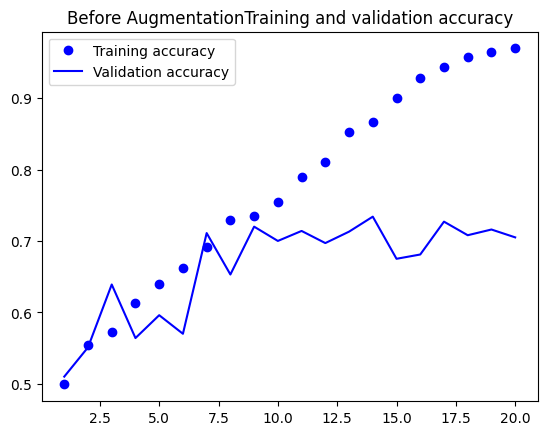

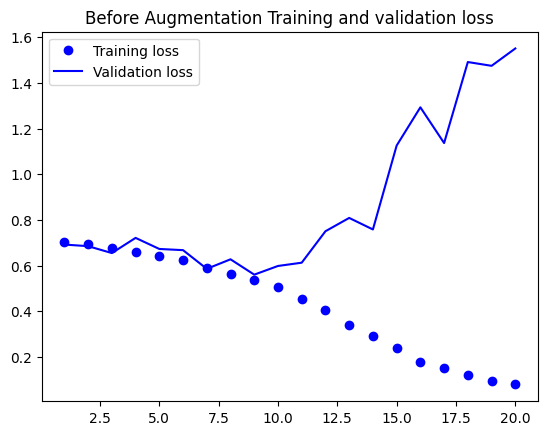

In [ ]:
import matplotlib.pyplot as plt
accuracy1 = history.history["accuracy"]
val_accuracy1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)
plt.plot(epochs, accuracy1, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy1, "b", label="Validation accuracy")
plt.title("Before AugmentationTraining and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, val_loss1, "b", label="Validation loss")
plt.title("Before Augmentation Training and validation loss")
plt.legend()
plt.show()

The overfitting qualities may be seen in the preceding plots, where validation accuracy is barely at 75% and training accuracy rises linearly over time to almost 100%. Additionally, after increasing rapidly for up to ten epochs, the validation loss stalls, whereas the training loss continues to decrease linearly as training goes on.


**Evaluating the model on test set**

Let's check test accuracy

In [ ]:
test_model1 = keras.models.load_model("conv_from_scratch1.keras")
test_loss, test_acc = test_model1.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 33ms/step - loss: 0.5411 - accuracy: 0.7330
Test accuracy: 0.733


we got a test accuracy of 70% because of less training data that leads to overfitting etc,. so that we need to work with specific one to computer vision when processing images with Deep learning models called Data Augmentation

**Data Augmentation**

To add an image model, define a data augmentation stage

In [ ]:
#we are doing random flip, random rotation, random zoom
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying randomly Augmented training images**

It's just like dropout where it overcome overfitting they're inactive during inference, it will behave as same model like when we not include data augmentation and dropout.

**Defining a convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

we train the model using data augmentation and dropout to overcome overfitting we will train as many number of times----100

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=20,
    validation_data=validation_datset,
     callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 8s 83ms/step - loss: 0.7123 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6882 - accuracy: 0.5565 - val_loss: 0.6748 - val_accuracy: 0.5940
Epoch 3/20
63/63 [==============================] - 4s 60ms/step - loss: 0.6779 - accuracy: 0.5980 - val_loss: 0.6638 - val_accuracy: 0.6420
Epoch 4/20
63/63 [==============================] - 7s 106ms/step - loss: 0.6644 - accuracy: 0.6210 - val_loss: 0.6529 - val_accuracy: 0.6430
Epoch 5/20
63/63 [==============================] - 4s 58ms/step - loss: 0.6586 - accuracy: 0.6160 - val_loss: 0.8199 - val_accuracy: 0.5080
Epoch 6/20
63/63 [==============================] - 6s 84ms/step - loss: 0.6383 - accuracy: 0.6520 - val_loss: 0.6372 - val_accuracy: 0.6550
Epoch 7/20
63/63 [==============================] - 4s 58ms/step - loss: 0.6209 - accuracy: 0.6625 - val_loss: 0.5997 - val_accuracy: 0.6910
Epoch 8/20
6

**Re-evaluating the model on the test dataset**

In [ ]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 29ms/step - loss: 0.4765 - accuracy: 0.7810
Test accuracy: 0.781


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 6s 60ms/step - loss: 0.7177 - accuracy: 0.4905 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 5s 83ms/step - loss: 0.6972 - accuracy: 0.5185 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 4s 58ms/step - loss: 0.6962 - accuracy: 0.5380 - val_loss: 0.6879 - val_accuracy: 0.5640
Epoch 4/20
63/63 [==============================] - 6s 85ms/step - loss: 0.6759 - accuracy: 0.5670 - val_loss: 0.6629 - val_accuracy: 0.5850
Epoch 5/20
63/63 [==============================] - 5s 80ms/step - loss: 0.6722 - accuracy: 0.5955 - val_loss: 0.6787 - val_accuracy: 0.5760
Epoch 6/20
63/63 [==============================] - 4s 57ms/step - loss: 0.6502 - accuracy: 0.6200 - val_loss: 0.6512 - val_accuracy: 0.5910
Epoch 7/20
63/63 [==============================] - 4s 56ms/step - loss: 0.6349 - accuracy: 0.6320 - val_loss: 0.6709 - val_accuracy: 0.5840
Epoch 8/20
63

In [ ]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.5081 - accuracy: 0.7570
Test accuracy: 0.757


**Using Image Augmentation and Dropout method**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Here a new convnet that includes both image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 6s 67ms/step - loss: 0.6952 - accuracy: 0.5070 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 6s 86ms/step - loss: 0.7000 - accuracy: 0.5250 - val_loss: 0.6895 - val_accuracy: 0.6000
Epoch 3/20
63/63 [==============================] - 6s 82ms/step - loss: 0.7043 - accuracy: 0.5610 - val_loss: 0.6792 - val_accuracy: 0.5790
Epoch 4/20
63/63 [==============================] - 4s 58ms/step - loss: 0.6857 - accuracy: 0.5790 - val_loss: 0.6813 - val_accuracy: 0.5540
Epoch 5/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6743 - accuracy: 0.5995 - val_loss: 0.6409 - val_accuracy: 0.6250
Epoch 6/20
63/63 [==============================] - 7s 95ms/step - loss: 0.6681 - accuracy: 0.6295 - val_loss: 0.6607 - val_accuracy: 0.5970
Epoch 7/20
63/63 [==============================] - 4s 60ms/step - loss: 0.6352 - accuracy: 0.6405 - val_loss: 0.6290 - val_accuracy: 0.6440
Epoch 8/20
63

**Evaluating the model on the test set**

In [ ]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.4599 - accuracy: 0.7840
Test accuracy: 0.784


2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

Here i am increasing the samples to 5000 and the model performance needs to be evaluated.

The technique here i am using data augmentation and dropout due to the performance was high based on the previous models by using this.

In [ ]:
make_subset("train__2", start_index=1000, end_index=8000)

train_dataset_2 = image_dataset_from_directory(
    new_dir / "train__2",
    image_size=(180, 180),
    batch_size=32)

Found 14000 files belonging to 2 classes.


New convnet that includes both image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training a reglularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_2,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
438/438 [==============================] - 129s 292ms/step - loss: 0.1675 - accuracy: 0.9354 - val_loss: 0.0674 - val_accuracy: 0.9800
Epoch 2/20
438/438 [==============================] - 134s 304ms/step - loss: 0.1503 - accuracy: 0.9417 - val_loss: 0.0588 - val_accuracy: 0.9800
Epoch 3/20
438/438 [==============================] - 133s 302ms/step - loss: 0.1334 - accuracy: 0.9493 - val_loss: 0.0569 - val_accuracy: 0.9770
Epoch 4/20
438/438 [==============================] - 131s 299ms/step - loss: 0.1255 - accuracy: 0.9515 - val_loss: 0.0590 - val_accuracy: 0.9790
Epoch 5/20
438/438 [==============================] - 132s 300ms/step - loss: 0.1201 - accuracy: 0.9561 - val_loss: 0.3475 - val_accuracy: 0.9320
Epoch 6/20
438/438 [==============================] - 131s 300ms/step - loss: 0.1147 - accuracy: 0.9569 - val_loss: 0.0686 - val_accuracy: 0.9830
Epoch 7/20
438/438 [==============================] - 132s 301ms/step - loss: 0.1196 - accuracy: 0.9564 - val_loss: 0.0552 -

In [ ]:
test_model= keras.models.load.model(
    "convent_from_scrath3.keras")
test_loss, test_acc=test_model.evaluate(test_dataset)
printf(f"Test Accuracy: {test_acc:.3f}")

3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results

Increased the samples from 8000 to 10000 in order to check the efficiency of the model

In [ ]:
make_subset("train_3", start_index=1000, end_index=10000)

train_dataset2 = image_dataset_from_directory(
    new_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)

Model Building with both Image augmentation and dropout

new convnet that includes both image augmentation and dropout

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_test1.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_2,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
438/438 [==============================] - 25s 54ms/step - loss: 0.6584 - accuracy: 0.5966 - val_loss: 0.5972 - val_accuracy: 0.7100
Epoch 2/20
438/438 [==============================] - 22s 50ms/step - loss: 0.5350 - accuracy: 0.7309 - val_loss: 0.5364 - val_accuracy: 0.7410
Epoch 3/20
438/438 [==============================] - 22s 50ms/step - loss: 0.4547 - accuracy: 0.7919 - val_loss: 0.5353 - val_accuracy: 0.7330
Epoch 4/20
438/438 [==============================] - 27s 61ms/step - loss: 0.3883 - accuracy: 0.8268 - val_loss: 0.3925 - val_accuracy: 0.8390
Epoch 5/20
438/438 [==============================] - 22s 50ms/step - loss: 0.3225 - accuracy: 0.8598 - val_loss: 0.3900 - val_accuracy: 0.8320
Epoch 6/20
438/438 [==============================] - 22s 49ms/step - loss: 0.2668 - accuracy: 0.8901 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 7/20
438/438 [==============================] - 22s 50ms/step - loss: 0.2155 - accuracy: 0.9109 - val_loss: 0.3531 - val_accuracy:

Evaluating the model with test set

In [ ]:
test_model4 = keras.models.load_model(
    "conv_from_scratch_test1.keras")
test_loss, test_acc = test_model4.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 66ms/step - loss: 0.3261 - accuracy: 0.8740
Test accuracy: 0.874


with dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_2,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
438/438 [==============================] - 25s 54ms/step - loss: 0.6954 - accuracy: 0.5421 - val_loss: 0.7436 - val_accuracy: 0.5240
Epoch 2/20
438/438 [==============================] - 26s 59ms/step - loss: 0.5879 - accuracy: 0.6922 - val_loss: 0.5297 - val_accuracy: 0.7560
Epoch 3/20
438/438 [==============================] - 29s 67ms/step - loss: 0.4926 - accuracy: 0.7676 - val_loss: 0.4792 - val_accuracy: 0.7700
Epoch 4/20
438/438 [==============================] - 23s 52ms/step - loss: 0.4227 - accuracy: 0.8101 - val_loss: 0.4400 - val_accuracy: 0.7940
Epoch 5/20
438/438 [==============================] - 25s 56ms/step - loss: 0.3610 - accuracy: 0.8407 - val_loss: 0.4546 - val_accuracy: 0.8020
Epoch 6/20
438/438 [==============================] - 23s 51ms/step - loss: 0.3122 - accuracy: 0.8685 - val_loss: 0.2915 - val_accuracy: 0.8770
Epoch 7/20
438/438 [==============================] - 22s 51ms/step - loss: 0.2650 - accuracy: 0.8896 - val_loss: 0.4001 - val_accuracy:

evaluating the model with test set

In [ ]:
test_model = keras.models.load_model(
    "conv_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.2916 - accuracy: 0.8730
Test accuracy: 0.873


4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance

**Pre-training model--1000 training samples**

Here install and freezing the VGG16 convolution base

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


Let's get the summary of the convbase

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fine-tuning a pretrained model

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

Freezing all layers except the last


Adding a data augmentation and a classifier to the convnet base.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

Training the regularized convnet

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
   train_datset,
   epochs=50,
   validation_data=validation_datset,
   callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 7s 68ms/step - loss: 0.7011 - accuracy: 0.4860 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6943 - accuracy: 0.5005 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 3/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6948 - accuracy: 0.5160 - val_loss: 0.6916 - val_accuracy: 0.5080
Epoch 4/50
63/63 [==============================] - 5s 70ms/step - loss: 0.6957 - accuracy: 0.5230 - val_loss: 0.6867 - val_accuracy: 0.5450
Epoch 5/50
63/63 [==============================] - 4s 61ms/step - loss: 0.6846 - accuracy: 0.5845 - val_loss: 0.7106 - val_accuracy: 0.5040
Epoch 6/50
63/63 [==============================] - 4s 62ms/step - loss: 0.6762 - accuracy: 0.5845 - val_loss: 0.7215 - val_accuracy: 0.5690
Epoch 7/50
63/63 [==============================] - 7s 98ms/step - loss: 0.6655 - accuracy: 0.6050 - val_loss: 0.6518 - val_accuracy: 0.6520
Epoch 8/50
63

Plotting the curves for loss and accuracy during training

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy with Data Augmentation")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss with Data Augmentation")
plt.legend()
plt.show()

Evaluating the model on the test set

In [ ]:
test_model5 = keras.models.load_model("convnet_from_scratch_augmentation.keras")
test_loss, test_acc = test_model5.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

Leveraging a Pretrained model

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Extracting the VGG16 features and corresponding labels by calling predict() method of the convolution base without Data Augmentation

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_datset)
val_features, val_labels = get_features_and_labels(validation_datset)
test_features, test_labels = get_features_and_labels(test_datset)

Defining and training the densely connected classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks)

Plotting the results

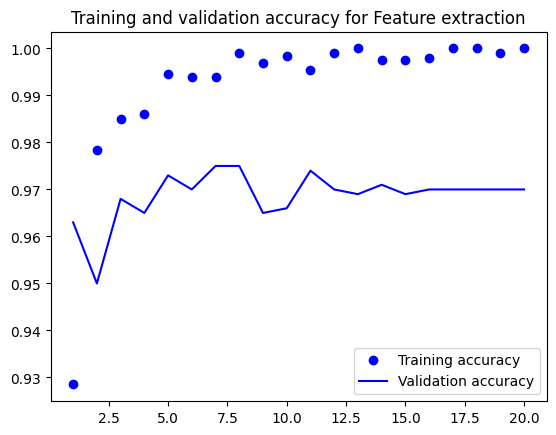

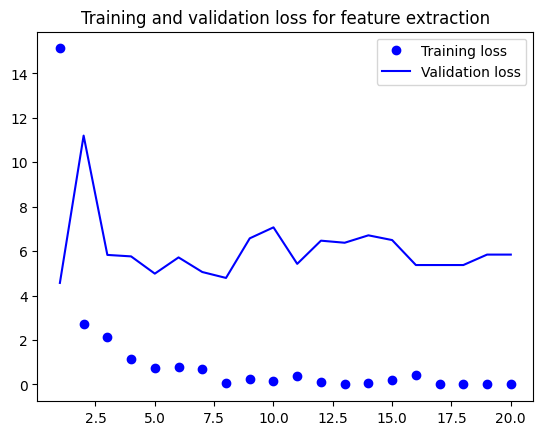

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Feature extraction")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss for feature extraction")
plt.legend()
plt.show()

Feature extraction with data augmentation

In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.summary()

Freezing all layers

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
 layer.trainable = False

Fine tuning a model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

Training the regularized network

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_datset,
 epochs=20,
 validation_data=validation_datset,
 callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 41s 453ms/step - loss: 2.3936 - accuracy: 0.5970 - val_loss: 0.5101 - val_accuracy: 0.7740
Epoch 2/20
63/63 [==============================] - 23s 357ms/step - loss: 0.6690 - accuracy: 0.6635 - val_loss: 0.2966 - val_accuracy: 0.8620
Epoch 3/20
63/63 [==============================] - 23s 358ms/step - loss: 0.5144 - accuracy: 0.7465 - val_loss: 0.2505 - val_accuracy: 0.8890
Epoch 4/20
63/63 [==============================] - 23s 361ms/step - loss: 0.4001 - accuracy: 0.8105 - val_loss: 0.1462 - val_accuracy: 0.9430
Epoch 5/20
63/63 [==============================] - 22s 345ms/step - loss: 0.3500 - accuracy: 0.8350 - val_loss: 0.2113 - val_accuracy: 0.9370
Epoch 6/20
63/63 [==============================] - 23s 367ms/step - loss: 0.2978 - accuracy: 0.8595 - val_loss: 0.1065 - val_accuracy: 0.9580
Epoch 7/20
63/63 [==============================] - 23s 357ms/step - loss: 0.2683 - accuracy: 0.8730 - val_loss: 0.1021 - val_accuracy: 0.9640

Plotting the curves of loss and accuracy during training for fine-tuning model

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the test set for fine-tuning

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

Pre-trianed model-5000 Training samples

same as we did above by installing and freezing the VGG16 conv base.

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Fine tuning the pretrained model by freezing the layers

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

By adding of augmentation and classifier to conv base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_2,
    epochs=10,
    validation_data=validation_datset,
    callbacks=callbacks)

evaluating the model with test set

In [ ]:
model = keras.models.load_model("fine_tuning2.keras")
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

Pre-trained model with 10000 samples by install and freezing the VGG16 comv base

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Fine tuning the pretrained model and freezing the layers except last one

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

By adding augmentation and classifier to the conv base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_datset,
    callbacks=callbacks)

Plotting the curves for loss and accuracy during training for fine tuning with 10000 samples

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model with test set

In [ ]:
model = keras.models.load_model("fine_tuning3.keras")
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

**Summary:**

1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

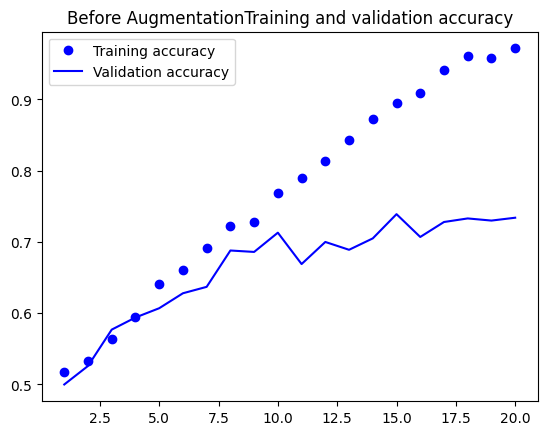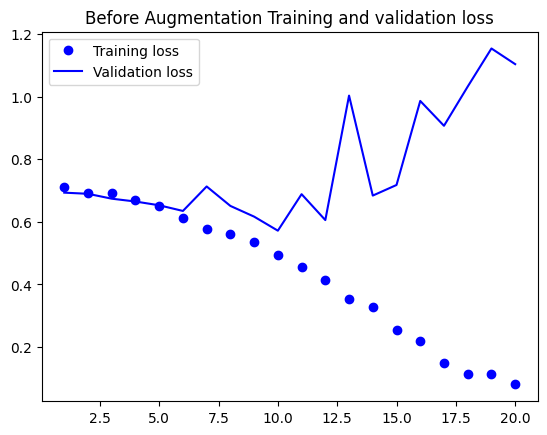

**Observations:**

• The graphs shown above are examples of overfitting. Whereas validation accuracy only reaches 70–72%, training accuracy rises linearly over time to almost 100%.
• Our primary problem will be overfitting because there aren't many training data. A number of strategies, including dropout, regularization, and data augmentation, can be used to lessen overfitting.

I have used three techniques to improve the performance of the model and evaluated all those three on test dataset on 100 epochs.

a) Drop out Method

b) Data Augmentation

c) Data Augmentation and drop out method.

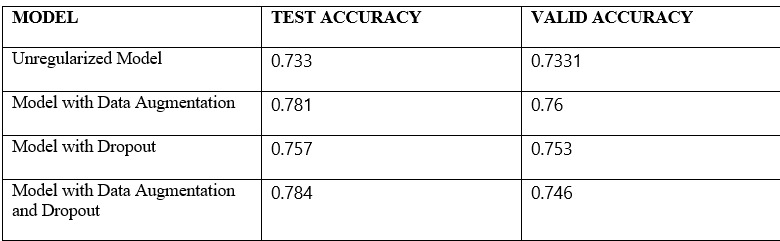

**Observations**:

• Based on the performance metrics of the models that combine the unregularized model with three performance improvement strategies, we can infer from the values in the above table that the model that incorporates both the dropout technique and data augmentation performs well.
• To regularize the model, I utilized the best-performing method—data augmentation and dropout—for the remaining training samples.


2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

• For this model I have increased the training sample size to 5000.

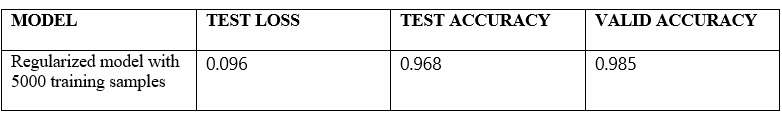

Observations:

•For regularized model it is observed that the loss: 0.3669 - accuracy: 0.848.

• In contrast to the unregularized model regularized model seems to have a bit higher accuracy.

• In comparison to the previous model the accuracy seems to be improved while the loss is slightly reduced.

3.Now change your training sample so that you achieve better performance than those from Steps1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results?

• For this model,I have increased sample size to

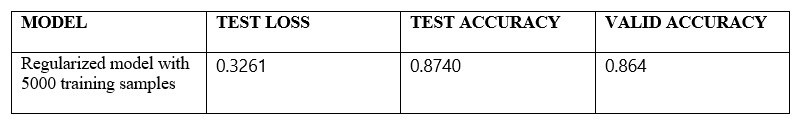

Observations:

From the above table,

• For regularized model it is observed that the loss: 0.22 - accuracy: 0.912

• In comparison with the unregularized model, this model is better.

Below is the chart that describes the comparison of test and validation accuracies for the different training samples size.

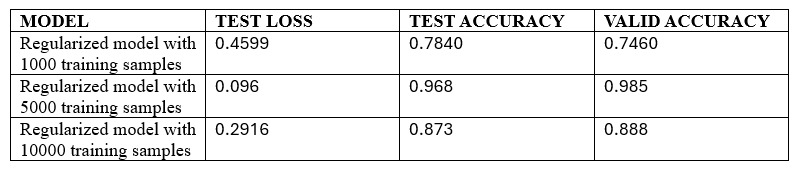

**Observations**:

• There is a correlation between test loss and training sample size, which shows that test loss decreases over time and the test accuracy increases from 86% to 92.2%, which shows a better improvement over time.

• Therefore, we can say that the performance of the model increases as the number of training samples increases.

**4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3,for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

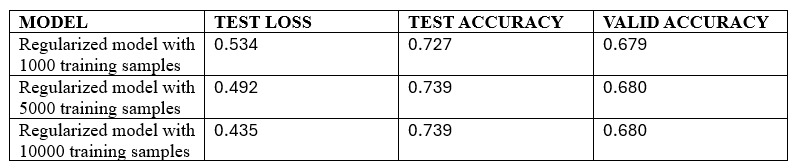

**Observations:**

We can observe from the data in the above table that when the training sample size rises, both the testing and validation accuracy tend to get better. As sample size grows, we observe a stronger improvement when test loss is taken into account.

**Recommendations**:

• Convolutional network-based machine learning models are the most successful in computer vision applications.

• When starting from scratch and training from a relatively little dataset, the outcomes can still be respectable.

• Overfitting is the fundamental issue with short datasets. Preventing overfitting in picture data can be effectively achieved by data augmentation techniques.

• Model performance rises as the amount of the training sample grows.

• We can improve the model's performance even further by fine-tuning the previously trained model.

